In [ ]:
def findexact(str, substr, index=0):
  offset = str.find(substr)
  ln = len(substr)
  if not index:
    return offset
  return offset + ln + findexact(str[offset+ln :], substr, index-1)

def multifind(str, substrs):
  ret = len(str)
  for substr in substrs:
    index = findexact(str, substr)
    if index > -1 and index < ret:
      ret = index
  if ret == len(str):
    ret = -1
  return ret

In [ ]:
!pip install gdown --quiet
!pip install docx2txt --quiet
!pip install pymorphy2 --quiet

import string
import gdown
import docx2txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

  Preparing metadata (setup.py) ... done


In [ ]:
!gdown 12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb

txt = docx2txt.process("CCXXXI: la Guirlande de Julie.docx")

Downloading...
From: https://drive.google.com/uc?id=12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb
To: /content/CCXXXI: la Guirlande de Julie.docx
100% 569k/569k [00:00<00:00, 118MB/s]


In [ ]:
months = ["vendémiaire", "brumaire", "frimaire", "nivôse", "pluviôse", "ventôse",
          "germinal", "floréal", "prairial", "messidor", "thermidor", "fructidor"]
for month in months:
  txt = txt.replace(month.upper(), "")

labels = ["monologue", "story", "fanfic", "chguestk", "moretta", "letter", "lyrics"]

df = pd.DataFrame(columns=["name", "day", "month", "greg_day", "greg_month", "label", "text"])

while(multifind(txt, labels) != -1):
  start = multifind(txt, labels)
  label = txt[start : txt.find(" ", start)]
  txt = txt[start + len(label) :]
  day = pd.Series({
      "name" : txt[findexact(txt, " ", 3) + 1 : findexact(txt, "\n")],
      "day" : int(txt[findexact(txt, " ", 1) + 1 : findexact(txt, " ", 2)]),
      "month" : txt[findexact(txt, " ", 2) + 1 : findexact(txt, ".", 1)],
      "greg_day" : int(txt[findexact(txt, "(") + 1 : findexact(txt, ".")]),
      "greg_month" : int(txt[findexact(txt, ".") + 1 : findexact(txt, ")")]),
      "label" : label,
      "text" : txt[findexact(txt, "\n", 1) + 1 : multifind(txt, labels)],
      "sentences" : None,
  })
  df = pd.concat([df, day.to_frame().T], ignore_index=True)

In [ ]:
df["words"] = df["text"].map(lambda x: len(x.replace("-", "").split()))
df["symbols"] = df["text"].map(lambda x: len(x.replace(" ", "")))
df["capitals"] = df["text"].map(lambda x: len(list(filter(lambda c: c.isupper(), x))))
df["dashes"] = df["text"].map(lambda x: len(list(filter(lambda w: w == "-", x.split()))))
df["questions"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "?", x))))
df["exclamations"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "!", x))))
df["newlines"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "\n", x))))
df["text"] = df["text"].map(lambda x: " ".join(x.split()))

df["sentences"] = df["text"].map(lambda x: len(x.replace("?", ".").replace("!", ".").replace("…", ".").split(". ")))

In [ ]:
df

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
0,raisin,1,vendémiaire,23,9,monologue,люди не изменились. ароматная жидкость мягко к...,17,238,1361,0,4,2,0,22
1,safran,2,vendémiaire,24,9,story,Сафран горд своим прозвищем. нет большого смыс...,21,333,1954,5,3,1,1,14
2,châtaigne,3,vendémiaire,25,9,story,Кристине исполняется четыре года. белокурая ма...,30,514,2838,10,13,5,2,14
3,colchique,4,vendémiaire,26,9,story,с тихим звонком открываются двери лифта. мягки...,39,339,1947,30,12,6,2,40
4,cheval,5,vendémiaire,27,9,story,Келлер Долль привычным движением запрыгивает в...,22,374,2266,10,4,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,pavot,18,prairial,7,6,letter,"я бы сказала, что мне это снилось, но такие но...",14,309,1760,0,7,0,0,10
258,tilleul,19,prairial,8,6,monologue,в детстве всё кажется намного больше - и ярче....,12,267,1500,0,8,3,0,6
259,fourche,20,prairial,9,6,fanfic,"кажется, люди иногда говорят, будто на одном п...",17,352,1879,1,8,2,0,6
260,barbeau,21,prairial,10,6,story,"встречаясь взглядом со своим отражением, Сара ...",16,361,2045,3,6,0,0,6


In [ ]:
df[df["label"] == "story"]#.sort_values(by=["words"], ascending=False)

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
1,safran,2,vendémiaire,24,9,story,Сафран горд своим прозвищем. нет большого смыс...,21,333,1954,5,3,1,1,14
2,châtaigne,3,vendémiaire,25,9,story,Кристине исполняется четыре года. белокурая ма...,30,514,2838,10,13,5,2,14
3,colchique,4,vendémiaire,26,9,story,с тихим звонком открываются двери лифта. мягки...,39,339,1947,30,12,6,2,40
4,cheval,5,vendémiaire,27,9,story,Келлер Долль привычным движением запрыгивает в...,22,374,2266,10,4,0,0,14
5,balsamine,6,vendémiaire,28,9,story,"по пустому переулку, освещённому тёплыми лучам...",34,529,2856,6,5,2,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,caille,15,prairial,4,6,story,"если вы захотите узнать, как здесь живётся люд...",19,431,2506,2,9,0,0,10
255,oeillet,16,prairial,5,6,story,площадь всё так же заполняет будничный шум - с...,14,305,1736,0,9,0,0,10
256,sureau,17,prairial,6,6,story,тёплое закатное солнце ласково заглядывает в о...,14,369,2010,0,6,1,0,6
260,barbeau,21,prairial,10,6,story,"встречаясь взглядом со своим отражением, Сара ...",16,361,2045,3,6,0,0,6


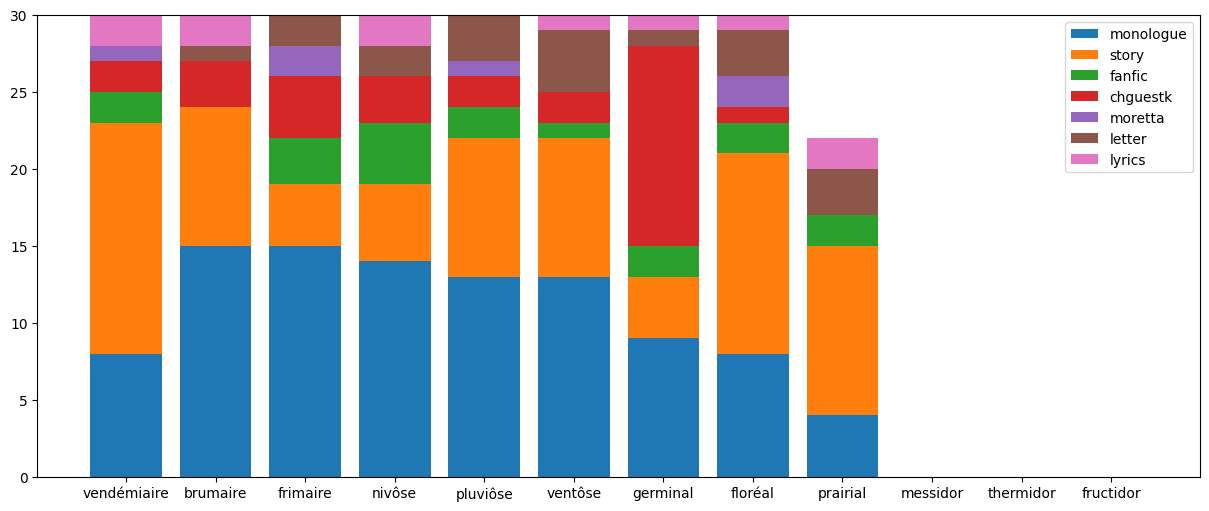

In [ ]:
fig = plt.figure(figsize=(15, 6))
bottom = np.zeros(len(months))
for label in labels:
  count = np.empty(0)
  for month in months:
    count = np.append(count, df[(df["month"] == month) & (df["label"] == label)].shape[0])
  plt.bar(np.asarray(months), count, label=label, bottom=bottom)
  bottom += count
plt.legend()
plt.show()

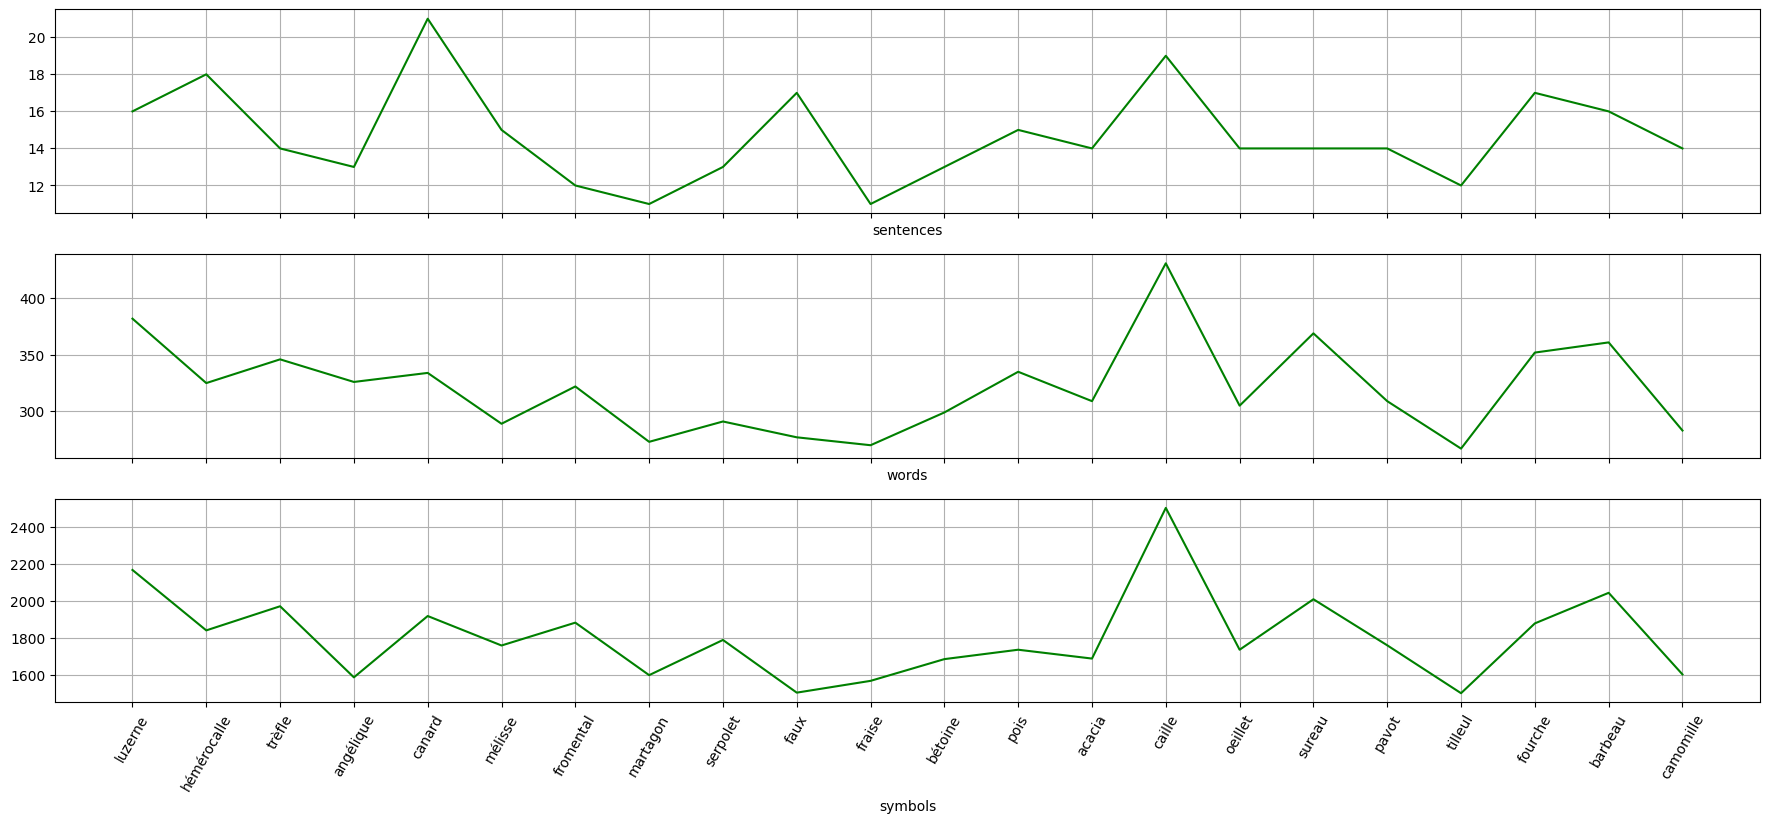

In [ ]:
batch = df[df["month"] == months[8]]

plots = ["sentences", "words", "symbols"]
# plots = ["capitals", "dashes", "questions", "exclamations", "newlines"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(batch.shape[0], 3 * len(plots)))
for i in range(len(plots)):
  axs[i].plot(batch["name"], batch[plots[i]], 'g')
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.xticks(rotation=60)
plt.show()

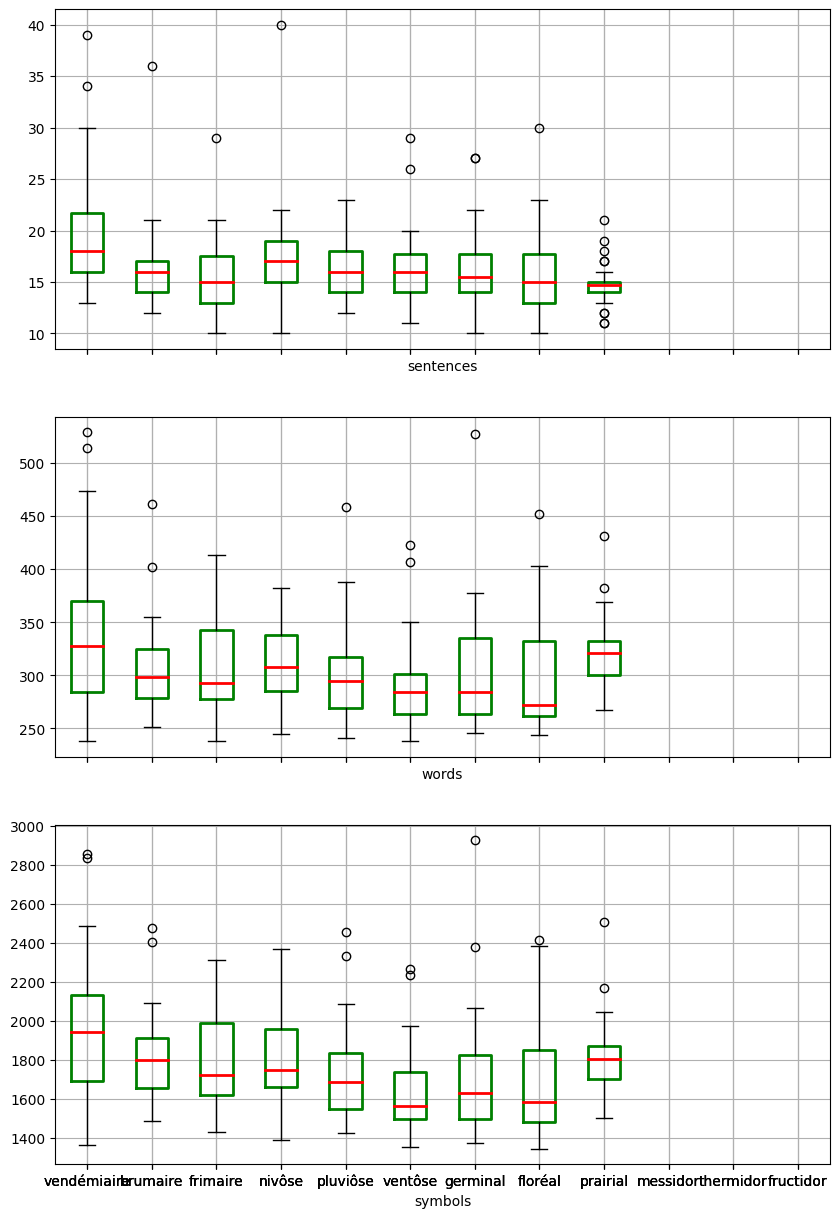

In [ ]:
boxprops = dict(linewidth=2, color='g')
medianprops = dict(linewidth=2, color='r')

plots = ["sentences", "words", "symbols"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(10, 5 * len(plots)))
for i in range(len(plots)):
  stat = pd.DataFrame(columns=months)
  for month in months:
    stat[month] = df[df["month"] == month][plots[i]].reset_index(drop=True)
    stat[month].fillna(stat[month].mean(), inplace=True)
  axs[i].boxplot(stat.to_numpy(), labels=stat.columns, widths=0.5, boxprops=boxprops, medianprops=medianprops)
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.suptitle("")
plt.show()

linreg MSE:  6.215189873417722
ridge MSE:  5.0316095681114


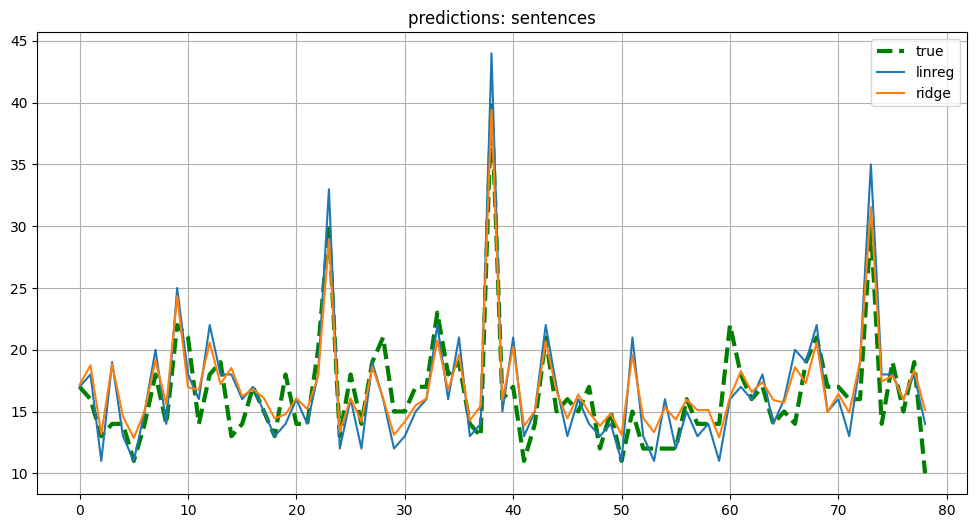

In [ ]:
target_column = "sentences"
dum_df = pd.get_dummies(data=df, columns=["month", "label"]).drop(columns=["name", "text"])
X, y = dum_df.drop(columns=[target_column]), dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

params = np.arange(0, 150, 1)
loss = []
for p in params:
  model = Ridge(alpha=p, random_state=88).fit(X_train, y_train)
  y_pred = model.predict(X_test)
  loss.append(mean_squared_error(y_test, y_pred))
alpha = params[np.argmin(loss)]

reg = LinearRegression().fit(X_train, y_train)
y_pred_reg = reg.predict(X_test).astype(int)
ridge = Ridge(alpha=alpha, random_state=88).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("linreg MSE: ", mean_squared_error(y_test, y_pred_reg))
print("ridge MSE: ", mean_squared_error(y_test, y_pred_ridge))

fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="true", color='g', linewidth=3, linestyle="dashed")
plt.plot(range(len(y_pred_reg)), y_pred_reg, label="linreg")
plt.plot(range(len(y_pred_ridge)), y_pred_ridge, label="ridge")
plt.title("predictions: " + target_column)
plt.grid()
plt.legend()
plt.show()

<Axes: >

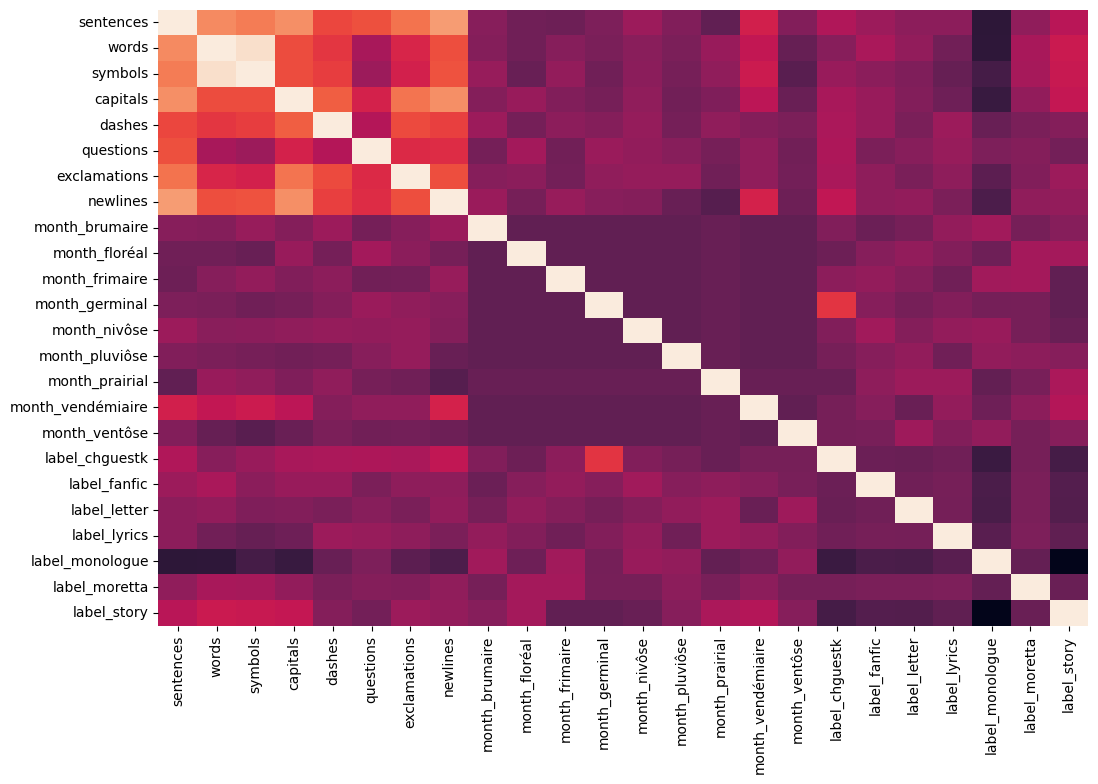

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(dum_df.corr(numeric_only=True), cbar=False)

In [23]:
print("chguestk by month:\n")
for month in months:
    print(month + ": " + str(df[(df["label"] == "chguestk") & (df["month"] == month)].shape[0]))

chguestk by month:

vendémiaire: 2
brumaire: 3
frimaire: 4
nivôse: 3
pluviôse: 2
ventôse: 2
germinal: 13
floréal: 1
prairial: 0
messidor: 0
thermidor: 0
fructidor: 0


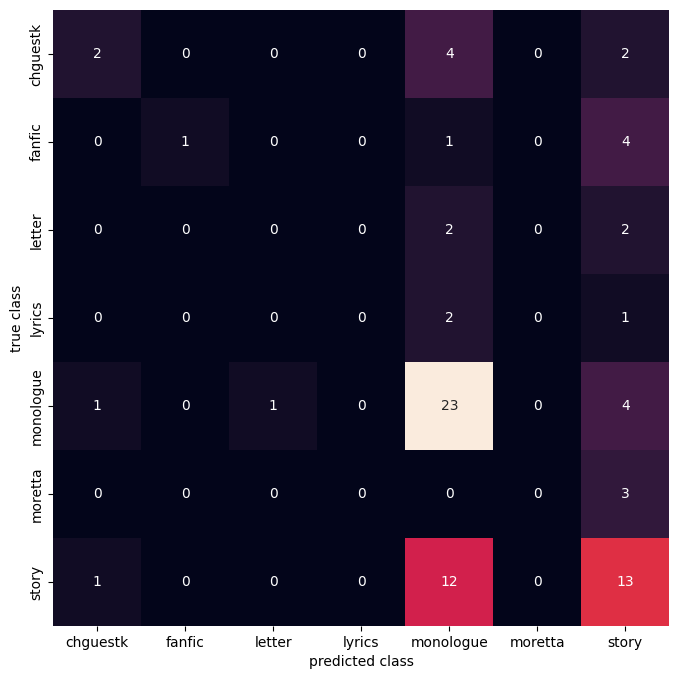

In [24]:
target_column = "label"
clf_dum_df = pd.get_dummies(data=df, columns=["month"]).drop(columns=["name", "text"])
X, y = clf_dum_df.drop(columns=[target_column]), clf_dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = RandomForestClassifier(random_state=88).fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

# print("accuracy: ", classification_report(y_test, y_pred_clf, labels=clf.classes_, zero_division=0, output_dict=True)["accuracy"])

fig = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_clf, labels=clf.classes_),
            xticklabels=clf.classes_, yticklabels=clf.classes_, annot=True, cbar=False, square=True)
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()

(-0.5, 7999.5, 3999.5, -0.5)

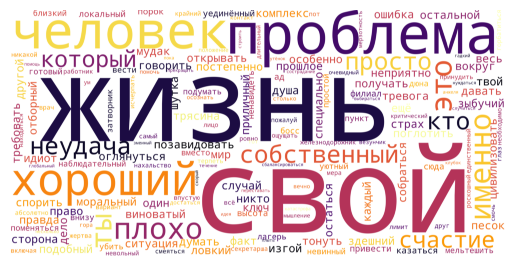

In [116]:
text_to_tokenize = " ".join(df[df["name"] == "canard"]["text"])
stop_words = set(stopwords.words("russian"))
tokens = word_tokenize(text_to_tokenize, language="russian")
tokens = [token.lower() for token in tokens if not token in stop_words and token.isalpha()]

morph = MorphAnalyzer()
tokens = [morph.normal_forms(token)[0] for token in tokens]
text_to_plot = " ".join(tokens)

wordcloud = WordCloud(
    stopwords=[],
    regexp=None,
    normalize_plurals=False,
    max_words=200,
    width=800,
    height=400,
    scale=10,
    relative_scaling=1,
    background_color="white",
    colormap="inferno",
    ).generate(text_to_plot)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")